In [1]:
from astropy.nddata import CCDData
import numpy as np
import matplotlib.pyplot as plt

from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import ApertureStats
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.io import fits
import ccdproc as ccdp
import astropy.units as u
import pandas as pd
from pathlib import Path
import os
from astropy.stats import mad_std
from astropy import modeling

from astroquery.simbad import Simbad
from astroquery.astrometry_net import AstrometryNet
from astropy.wcs import WCS
from astropy import coordinates

In [2]:
#name strings for fits files and csv files
fits = '.fits'
csv = '_stars.csv'

#filter specific file names
luminance = 'star_Light_Luminance_5_secs_001_reduced'
#luminance = 'star_Light_Luminance_10_secs_001_reduced'
#luminance = 'RZ_Cep_Light_Luminance_10_secs_001_reduced'
#luminance = 'Light_Luminance_3.500_secs_001_reduced'
red = 'star_Light_Red_18_secs_001_reduced'
green = 'star_Light_Green_18_secs_001_reduced'
blue = 'star_Light_Blue_18_secs_001_reduced'

#set current filter
ref_image_name = luminance + fits
ref_csv_name = luminance + csv
current_filter = 'Luminance'

#define path for csv files to be written to
csv_path = Path(f'./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/CSVs/Unmatched Stars/{current_filter}')
#csv_path = Path(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/CSVs/Unmatched Stars/{current_filter}')
#csv_path = Path(f'./RZ Cep/All_RZ_Cep/2023_02_23/RZ_Cep/CSVs/Unmatched Stars/{current_filter}')
#csv_path = Path(f'./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/CSVs/Unmatched Stars/{current_filter}')

#set the path to the images we are looking at
current_raw_path = f'./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/Lights/{current_filter} Reduced/'
#current_raw_path = f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Lights/{current_filter} Reduced/'
#current_raw_path = f'./RZ Cep/All_RZ_Cep/2023_02_23/RZ_Cep/Lights/{current_filter} Reduced/'
#current_raw_path = f'./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/Lights/{current_filter} Reduced/'
#create a list of files in the directory (file) indicated by the path, just in case some sub folders exist or files that are
#not of the FITS type.
file_list = [f for f in os.listdir(current_raw_path) if f.endswith('.fits')]

#convert the path from a string into a Path object that can be put into functions
raw_path = Path(current_raw_path)
#read in the images
raw_ims = ccdp.ImageFileCollection(raw_path, filenames=file_list)

# Estimate Star Position, hence FWHM #

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


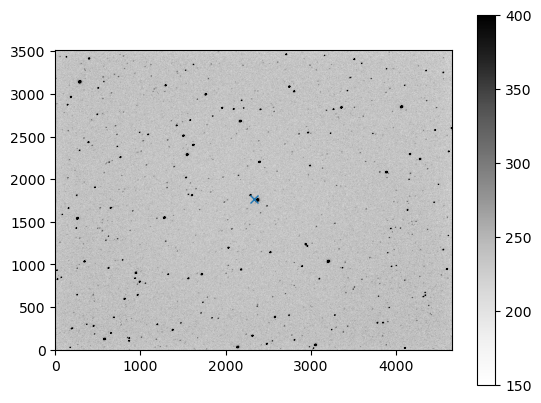

In [3]:
#read in raw image
raw_im = CCDData.read(raw_path / ref_image_name)

#plot the image, scaling it to see more of the stars
plt.imshow(raw_im.data, cmap='Greys', vmin=150, vmax=400)
plt.gca().invert_yaxis()
#plot an x to estimate star position
plt.plot(2330, 1770, marker='x')
plt.colorbar()
plt.show()

Text(0, 0.5, 'Recieved Counts (photons)')

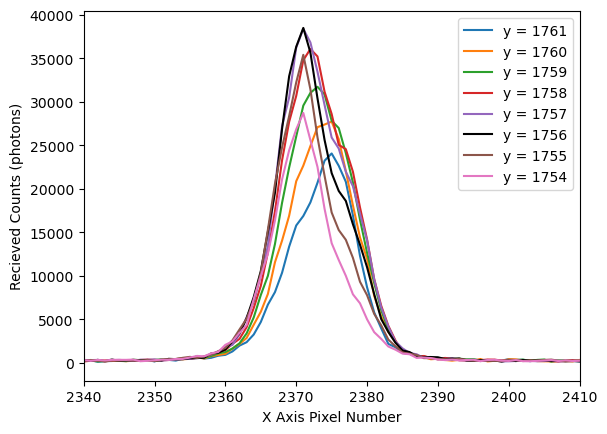

In [4]:
#plot a slice of the image at y = pix value
plt.plot(raw_im.data[1761], label='y = 1761')
plt.plot(raw_im.data[1760], label='y = 1760')
plt.plot(raw_im.data[1759], label='y = 1759')
plt.plot(raw_im.data[1758], label='y = 1758')
plt.plot(raw_im.data[1757], label='y = 1757')
plt.plot(raw_im.data[1756], label='y = 1756', color='k')
plt.plot(raw_im.data[1755], label='y = 1755')
plt.plot(raw_im.data[1754], label='y = 1754')
plt.legend()

y_peak_loc = 1756
y_peak_height = 38000
#peaks at y_pix = 1793 for 2022_12_07, so this is the approximate y location (height = 16000)
#peaks at y_pix = 1756 for 2023_01_23, so this is the approximate y location (height = 38000)
#peaks at y_pix = 1757 for 2023_02_23, so this is the approximate y location (height = 41000)
#peaks at y_pix = 1757 for 2023_11_10, so this is the approximate y location (height = 34000)

#find the rough location of the peak (range)
plt.xlim(2340, 2410)

plt.xlabel('X Axis Pixel Number')
plt.ylabel('Recieved Counts (photons)')

Text(0, 0.5, 'Recieved Counts (photons)')

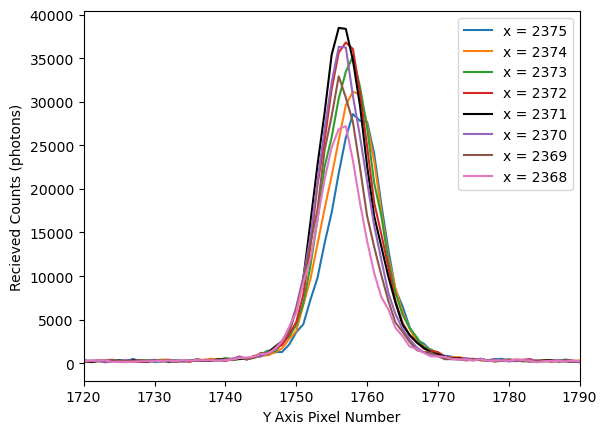

In [5]:
#plot a slice of the image across the x axis
plt.plot(raw_im.data[:, 2375], label='x = 2375')
plt.plot(raw_im.data[:, 2374], label='x = 2374')
plt.plot(raw_im.data[:, 2373], label='x = 2373')
plt.plot(raw_im.data[:, 2372], label='x = 2372')
plt.plot(raw_im.data[:, 2371], label='x = 2371', color='k')
plt.plot(raw_im.data[:, 2370], label='x = 2370')
plt.plot(raw_im.data[:, 2369], label='x = 2369')
plt.plot(raw_im.data[:, 2368], label='x = 2368')
plt.legend()

#if less iterations, initial guess was more accurate

x_peak_loc = 2371
x_peak_height = 38000
#peaks at x_pix = 2365 for 2022_12_07, so this is the approximate location (height = 16000)
#peaks at x_pix = 2371 for 2023_01_23, so this is the approximate location (height = 38000)
#peaks at x_pix = 2335 for 2023_02_23, so this is the approximate location (height = 41000)
#peaks at x_pix = 2420 for 2023_11_10, so this is the approximate location (height = 32000)

#find approximate peak location range
plt.xlim(1720, 1790)

plt.xlabel('Y Axis Pixel Number')
plt.ylabel('Recieved Counts (photons)')

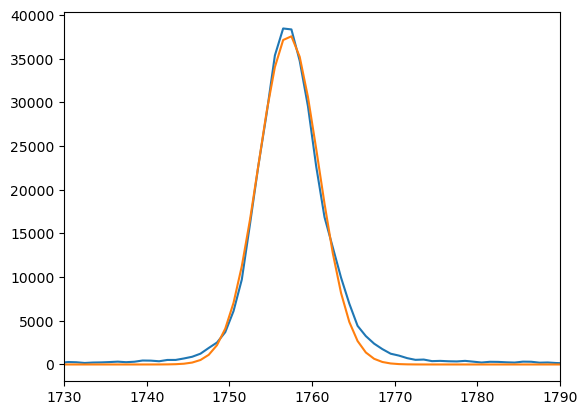

19222.570298632643
1761
10


In [6]:
#defined a fitter algorithm for fitting the Gaussian, in this case the Levenberg-Marquardt, which uses a least squares method
algorithm = modeling.fitting.LevMarLSQFitter()
#define Gaussian to fit, with test peak value, mean and standard deviation
#mean found from approx y location
model_y = modeling.models.Gaussian1D(y_peak_height, y_peak_loc, 3)

#define the x range of the data (AKA the number of pixels in the y direction)
x_range_y = np.linspace(0, len(raw_im.data[:, x_peak_loc]), len(raw_im.data[:, x_peak_loc]))
#apply the algortihm to the model, which fits the model to the data
gaussian_fit_y = algorithm(model_y, x_range_y, raw_im.data[:, x_peak_loc])

#plot original data and Gaussian curve to find new trial values
plt.plot(x_range_y, raw_im.data[:, x_peak_loc])
plt.plot(x_range_y, gaussian_fit_y(x_range_y))
plt.xlim(1730, 1790)
plt.show()

#find the half height of the gaussian
half_max_y = (np.max(raw_im.data[:, x_peak_loc]) - np.min(raw_im.data[:, x_peak_loc]))/2
print(half_max_y)

#find the closest data point and print its index (argmin returns the index)
closest_y = (np.abs(gaussian_fit_y(x_range_y)-half_max_y)).argmin()
print(closest_y)

#this is the full width half maximum of the star in y direction. 
FWHM_y = np.abs(closest_y - y_peak_loc) * 2
print(FWHM_y)

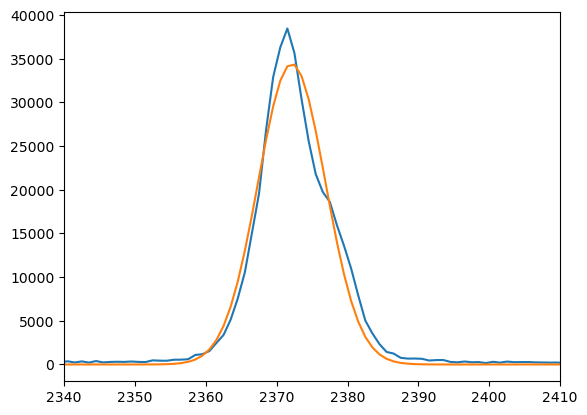

19220.327078739345
2377
12
11.0


In [7]:
#define Gaussian to fit, with test peak value, mean and standard deviation
#mean found from approx y location
model_x = modeling.models.Gaussian1D(x_peak_height, x_peak_loc, 3)

#define the x range of the data (AKA the number of pixels in the x direction)
x_range_x = np.linspace(0, len(raw_im.data[y_peak_loc]), len(raw_im.data[y_peak_loc]))
#apply the algortihm to the model, which fits the model to the data
gaussian_fit_x = algorithm(model_x, x_range_x, raw_im.data[y_peak_loc])

#plot original data and Gaussian curve to find new trial values
plt.plot(x_range_x, raw_im.data[y_peak_loc])
plt.plot(x_range_x, gaussian_fit_x(x_range_x))
plt.xlim(2340, 2410)
plt.show()

#find the half height of the gaussian
half_max_x = (np.max(raw_im.data[y_peak_loc]) - np.min(raw_im.data[y_peak_loc]))/2
print(half_max_x)

#find the closest data point and print its index (argmin returns the index)
closest_x = (np.abs(gaussian_fit_x(x_range_x)-half_max_x)).argmin()
print(closest_x)

#this is the full width half maximum of the star in x direction. 
FWHM_x = np.abs(closest_x - x_peak_loc) * 2
print(FWHM_x)
FWHM_trial = (FWHM_x + FWHM_y)/2
print(FWHM_trial)

# Perform Aperture Photometry on All Stars #

In [3]:
#for tracking how many files operations have been completed
i = 0

for light, file_name in raw_ims.ccds(imagetyp='Light Frame', ccd_kwargs={'unit':'adu'}, return_fname=True):
    '''setup'''
    #read in header to find the date and time the image was taken
    date_time = CCDData.read(raw_path / file_name).header['DATE-OBS']
    exptime = CCDData.read(raw_path / file_name).header['EXPTIME']
    #assume a starting fwhm similar to that of the original image, x2 for 2022 as images are out of focus
    FWHM = 12.0
    #ensure we are working with only the image data
    light = light.data
    #find image stats of target image
    bkg_mean, bkg_median, bkg_std = sigma_clipped_stats(light, sigma=4, stdfunc=mad_std)
    #rename the files
    file_name = file_name.replace('.fits', '_stars')
    print('setup done')

    '''search for stars in the image'''
    #use DAOStarFinder algorithm to search for stars
    daofind = DAOStarFinder(fwhm=FWHM, threshold=5 * bkg_std, brightest=5)
    #subtract background median to reduce effect of background noise
    stars = daofind(light - bkg_median)
    
    del(daofind) #mem saving
    print('initial star search done')
    
    '''find an updated full-width-half-maximum'''
    #define new array of all star positions
    newstars = np.transpose((stars['xcentroid'], stars['ycentroid']))
    #define circular apertures for all star positions
    apertures = CircularAperture(newstars, r=FWHM*2)
    #use the apertures to find image specific fwhm
    '''bad nasty code line that means loop breaks unless median background is subtracted'''
    aperstats = ApertureStats(light-bkg_median, apertures)
    new_FWHM = aperstats.fwhm
    #aperstats outputs as a Quantity datatype, convert back to a number
    FWHM = float(np.median(new_FWHM) / (1 * u.pix))
    print('updated full-width-half-maximum')
    
    '''find stars again using new full-width-half-maximum'''
    #set up new star finder
    '''IMPORTANT: Images beyond the first few in 2023_01_23 have much less noise, possibly due to absent cloud cover. 
    The first few were the ones used in trials, so a lower threshold is needed to detect all stars than initially thought.'''
    '''In the 2022_12_07, a threshold of four doesn't detect enough stars in image 141'''
    daofind2 = DAOStarFinder(fwhm=FWHM, threshold=4*bkg_std, brightest=150)
    #subtract background median to reduce noise again
    stars2 = daofind2(light - bkg_median)
    #define new array of all star positions
    newstars2 = np.transpose((stars2['xcentroid'], stars2['ycentroid']))
    print('secondary search done')

    '''set up new apertures and annuli for aperture photometry'''
    #define radius of aperture
    r = FWHM * 3.5
    #define radius of annulus, so that it has the same area as the aperture
    r_a = (np.sqrt(2) - 1) * r
    #define apertures and annuli
    apertures2 = CircularAperture(newstars2, r=r)
    annuli = CircularAnnulus(newstars2, r_in=r, r_out=r+r_a)
    print('apertures and annuli defined')
    
    '''test for saturation'''
    #define saturation level. factor is arbitrary and chosen by us, correcting for non linearity is 
    #beyond the scope of our projects
    sat_level = np.power(2, 16) * 0.8
    #set up aperture stats without background subtracted
    ap_stats = ApertureStats(light, apertures2)

    #test if pixels are saturated
    j = 0
    saturated = []
    while j < 150:
        if sat_level <= ap_stats.max[j]:
            print('star', j, 'is close to saturated')
            saturated.append(True)
            j += 1
        else:
            saturated.append(False)
            j += 1 
    print('tested for saturation')

    '''isolate useful image properties and perform aperture photometry for the rest'''
    #run aperturestats on annuli
    an_stats = ApertureStats(light, annuli)
    #perform aperture photometry with new apertures
    phot_table = aperture_photometry(light, apertures2)
    #extract recorded counts for the star
    counts = np.array(phot_table['aperture_sum'])
    #extract sky value of the annunli using their median and multiplying it by the total area of the aperture
    #more accurate background that is star specfic
    sky = an_stats.median * np.pi * (r ** 2)
    #correct the aperture photometry for the sky value, counts are now purely from star
    corr_counts = counts - sky
    #calculate flux using exposure time, set to 1 to correct for exposure time later
    flux = corr_counts / 1.0
    #calculate instrumental magnitude from flux
    inst_mag = -2.5 * np.log10(flux)
    #save sharpness and roundness from daostarfinder for histogram plotting purposes
    sharp = stars2['sharpness']
    round_ = stars2['roundness1']
    round__ = stars2['roundness2']
    #save aperturestats
    ellipticity = ap_stats.ellipticity
    #save errors
    counts_error = np.sqrt(corr_counts)
    flux_error = counts_error / 1.0
    mag_error = 1.0857 * (flux_error / flux) #poisson stats, see photo taken
    print('aperture photometry completed')
   
    '''write to a dataframe'''
    #set up dataframe of 150 star positions and flux read from aperture photometry
    x_center = np.transpose(stars2['xcentroid'])
    y_center = np.transpose(stars2['ycentroid'])
    annulus_bkg = sky
    counts_raw = counts
    FWHM_arr = np.full(150, FWHM)
    date_arr = [date_time] * 150
    exp_time = [exptime] * 150
    sky_corr_counts = corr_counts
    flux_calc = flux
    mag_calc = inst_mag
    corr_mag = inst_mag + 2.5 * np.log10(exptime)
    print('dataframe info isolated')
   
    '''write to a csv file'''
    df = pd.DataFrame(data=(x_center, y_center, annulus_bkg, counts_raw, sky_corr_counts, counts_error, 
                            flux_calc, flux_error, mag_calc, mag_error, corr_mag, saturated, FWHM_arr, date_arr, 
                            exp_time, sharp, round_, round__, ellipticity))
    df = df.T
    df.columns = ['x_center', 'y_center', 'annulus_bkg', 'counts', 'sky_corrected_counts', 'counts_error', 
                  'flux', 'flux_error', 'instrumental_mag', 'mag_error', 'corrected_mag', 'saturated?', 'FWHM', 'date_time', 'exp_time', 
                  'sharpness', 'roundness_sym', 'roundness_gauss', 'ellipticity']
    #write csv file contating positions and fluxes for that image
    df.to_csv(csv_path / f'{file_name}.csv')
    print('dataframe created')
    #track how many files have been through the loop
    i += 1
    print('csv file written, ', i, 'files completed')

print('all done!!!')

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done


C:\ProgramData\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  1 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  2 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  3 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  4 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  5 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  6 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  7 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  8 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  9 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  10 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  11 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  12 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  13 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  14 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  15 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  16 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  17 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  18 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  19 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  20 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  21 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  22 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  23 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  24 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  25 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  26 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  27 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  28 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  29 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  30 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  31 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  32 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  33 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  34 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  35 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  36 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  37 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  38 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  39 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  40 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  41 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  42 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  43 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  44 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  45 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  46 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  47 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  48 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  49 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  50 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  51 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  52 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  53 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  54 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  55 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  56 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  57 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  58 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  59 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  60 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  61 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  62 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  63 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  64 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  65 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  66 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  67 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  68 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  69 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  70 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  71 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  72 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  73 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  74 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  75 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  76 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  77 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  78 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  79 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  80 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  81 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  82 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  83 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  84 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  85 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  86 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  87 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  88 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  89 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  90 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  91 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  92 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  93 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  94 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  95 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  96 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  97 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  98 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  99 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  100 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  101 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  102 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  103 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  104 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  105 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  106 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  107 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  108 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  109 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  110 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  111 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  112 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  113 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  114 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  115 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  116 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  117 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  118 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  119 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  120 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  121 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  122 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  123 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  124 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  125 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  126 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  127 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  128 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  129 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  130 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  131 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  132 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  133 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  134 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  135 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  136 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  137 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  138 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  139 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  140 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  141 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  142 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  143 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  144 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  145 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  146 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  147 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  148 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  149 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  150 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  151 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  152 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  153 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  154 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  155 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  156 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  157 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  158 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  159 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  160 files completed
all done!!!


C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_18704\2332935626.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


In [13]:
# #for tracking how many files operations have been completed
# i = 0
# light, file_name = next(raw_ims.ccds(imagetyp='Light Frame', ccd_kwargs={'unit':'adu'}, return_fname=True))
# light = light.data

# for r in range(1, 101):
#     '''setup'''
#     #read in header to find the date and time the image was taken
#     date_time = CCDData.read(raw_path / file_name).header['DATE-OBS']
#     exptime = CCDData.read(raw_path / file_name).header['EXPTIME']
#     #assume a starting fwhm similar to that of the original image, x2 for 2022 as images are out of focus
#     FWHM = FWHM_trial * 2
#     #ensure we are working with only the image data

#     #find image stats of target image
#     bkg_mean, bkg_median, bkg_std = sigma_clipped_stats(light, sigma=4, stdfunc=mad_std)
#     #rename the files
#     file_name_new = (f'Radius{r}Test')
#     print('setup done')

#     '''search for stars in the image'''
#     #use DAOStarFinder algorithm to search for stars
#     daofind = DAOStarFinder(fwhm=FWHM, threshold=5 * bkg_std, brightest=5)
#     #subtract background median to reduce effect of background noise
#     stars = daofind(light - bkg_median)
    
#     del(daofind) #mem saving
#     print('initial star search done')
    
#     '''find an updated full-width-half-maximum'''
#     #define new array of all star positions
#     newstars = np.transpose((stars['xcentroid'], stars['ycentroid']))
#     #define circular apertures for all star positions
#     apertures = CircularAperture(newstars, r=FWHM*2)
#     #use the apertures to find image specific fwhm
#     '''bad nasty code line that means loop breaks unless median background is subtracted'''
#     aperstats = ApertureStats(light-bkg_median, apertures)
#     new_FWHM = aperstats.fwhm
#     #aperstats outputs as a Quantity datatype, convert back to a number
#     FWHM = float(np.median(new_FWHM) / (1 * u.pix))
#     print('updated full-width-half-maximum')
    
#     '''find stars again using new full-width-half-maximum'''
#     #set up new star finder
#     '''IMPORTANT: Images beyond the first few in 2023_01_23 have much less noise, possibly due to absent cloud cover. 
#     The first few were the ones used in trials, so a lower threshold is needed to detect all stars than initially thought.'''
#     '''In the 2022_12_07, a threshold of four doesn't detect enough stars in image 141'''
#     daofind2 = DAOStarFinder(fwhm=FWHM, threshold=4*bkg_std, brightest=150)
#     #subtract background median to reduce noise again
#     stars2 = daofind2(light - bkg_median)
#     #define new array of all star positions
#     newstars2 = np.transpose((stars2['xcentroid'], stars2['ycentroid']))
#     print('secondary search done')

#     '''set up new apertures and annuli for aperture photometry'''
#     #define radius of aperture
#     #r = FWHM * 3
#     #define radius of annulus, so that it has the same area as the aperture
#     r_a = (np.sqrt(8)/2 - 1) * r
#     #define apertures and annuli
#     apertures2 = CircularAperture(newstars2, r=r)
#     annuli = CircularAnnulus(newstars2, r_in=r, r_out=r+r_a)
#     print('apertures and annuli defined')
    
#     '''test for saturation'''
#     #define saturation level. factor is arbitrary and chosen by us, correcting for non linearity is 
#     #beyond the scope of our projects
#     sat_level = np.power(2, 16) * 0.8
#     #set up aperture stats without background subtracted
#     ap_stats = ApertureStats(light, apertures2)

#     #test if pixels are saturated
#     j = 0
#     saturated = []
#     while j < 150:
#         if sat_level <= ap_stats.max[j]:
#             print('star', j, 'is close to saturated')
#             saturated.append(True)
#             j += 1
#         else:
#             saturated.append(False)
#             j += 1 
#     print('tested for saturation')

#     '''isolate useful image properties and perform aperture photometry for the rest'''
#     #run aperturestats on annuli
#     an_stats = ApertureStats(light, annuli)
#     #perform aperture photometry with new apertures
#     phot_table = aperture_photometry(light, apertures2)
#     #extract recorded counts for the star
#     counts = np.array(phot_table['aperture_sum'])
#     #extract sky value of the annunli using their median and multiplying it by the total area of the aperture
#     #more accurate background that is star specfic
#     sky = an_stats.median * np.pi * (r ** 2)
#     #correct the aperture photometry for the sky value, counts are now purely from star
#     corr_counts = counts - sky
#     #calculate flux using exposure time, set to 1 to correct for exposure time later
#     flux = corr_counts / 1.0
#     #calculate instrumental magnitude from flux
#     inst_mag = -2.5 * np.log10(flux)
#     #save sharpness and roundness from daostarfinder for histogram plotting purposes
#     sharp = stars2['sharpness']
#     round_ = stars2['roundness1']
#     round__ = stars2['roundness2']
#     #save aperturestats
#     ellipticity = ap_stats.ellipticity
#     #save errors
#     counts_error = np.sqrt(corr_counts)
#     flux_error = counts_error / 1.0
#     mag_error = 2.5 / (flux_error * np.log(10))
#     print('aperture photometry completed')
   
#     '''write to a dataframe'''
#     #set up dataframe of 150 star positions and flux read from aperture photometry
#     x_center = np.transpose(stars2['xcentroid'])
#     y_center = np.transpose(stars2['ycentroid'])
#     annulus_bkg = sky
#     counts_raw = counts
#     FWHM_arr = np.full(150, FWHM)
#     date_arr = [date_time] * 150
#     exp_time = [exptime] * 150
#     ap_rad = [r] * 150
#     an_rad = [r_a] * 150
#     sky_corr_counts = corr_counts
#     flux_calc = flux
#     mag_calc = inst_mag
#     corr_mag = inst_mag + 2.5 * np.log10(exptime)
#     print('dataframe info isolated')
   
#     '''write to a csv file'''
#     df = pd.DataFrame(data=(x_center, y_center, annulus_bkg, counts_raw, sky_corr_counts, counts_error, 
#                             flux_calc, flux_error, mag_calc, mag_error, corr_mag, saturated, FWHM_arr, date_arr, 
#                             exp_time, sharp, round_, round__, ellipticity, ap_rad, an_rad))
#     df = df.T
#     df.columns = ['x_center', 'y_center', 'annulus_bkg', 'counts', 'sky_corrected_counts', 'counts_error', 
#                   'flux', 'flux_error', 'instrumental_mag', 'mag_error', 'corrected_mag', 'saturated?', 'FWHM', 'date_time', 'exp_time', 
#                   'sharpness', 'roundness_sym', 'roundness_gauss', 'ellipticity', 'aperture_radius', 'annulus_radius']
#     #write csv file contating positions and fluxes for that image
#     df.to_csv(Path('./RZ Cep/All_RZ_Cep/Photometry Test') / f'{file_name_new}.csv')
#     print('dataframe created')
#     #track how many files have been through the loop
#     i += 1
#     print('csv file written, ', i, 'files completed')

# print('all done!!!')

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  1 files completed
setup done
initial star search done
updated full-width-half-maximum


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  2 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  3 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  4 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  5 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  6 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  7 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  8 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  9 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  10 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  11 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  12 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  13 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  14 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  15 files completed
setup done
initial star search done
updated full-width-half-maximum


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  16 files completed
setup done
initial star search done
updated full-width-half-maximum


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  17 files completed
setup done
initial star search done
updated full-width-half-maximum


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  18 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  19 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  20 files completed
setup done
initial star search done
updated full-width-half-maximum


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  21 files completed
setup done
initial star search done
updated full-width-half-maximum


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  22 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  23 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  24 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  25 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  26 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  27 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  28 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  29 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  30 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  31 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  32 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  33 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  34 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  35 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  36 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  37 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  38 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  39 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


dataframe created
csv file written,  40 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  41 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  42 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  43 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


dataframe created
csv file written,  44 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  45 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


dataframe created
csv file written,  46 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  47 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


dataframe created
csv file written,  48 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


dataframe created
csv file written,  49 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  50 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  51 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  52 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  53 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  54 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  55 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  56 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  57 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  58 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  59 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  60 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  61 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  62 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  63 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  64 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  65 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  66 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  67 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  68 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  69 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  70 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  71 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  72 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  73 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  74 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  75 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  76 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  77 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  78 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  79 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  80 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  81 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  82 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  83 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  84 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  85 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  86 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  87 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  88 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  89 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  90 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  91 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  92 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  93 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  94 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  95 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  96 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  97 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  98 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  99 files completed
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  100 files completed
all done!!!


C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:100: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_19800\4030089591.py:108: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


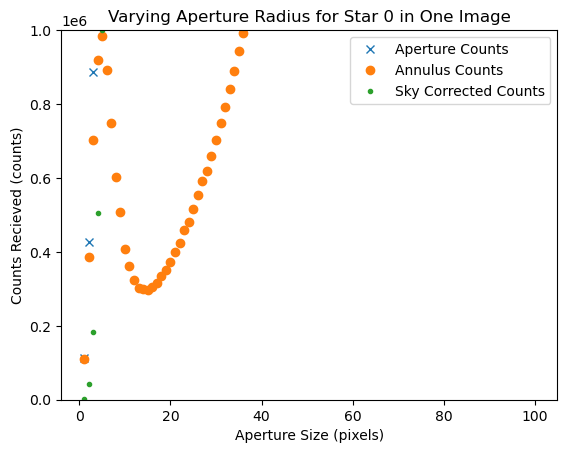

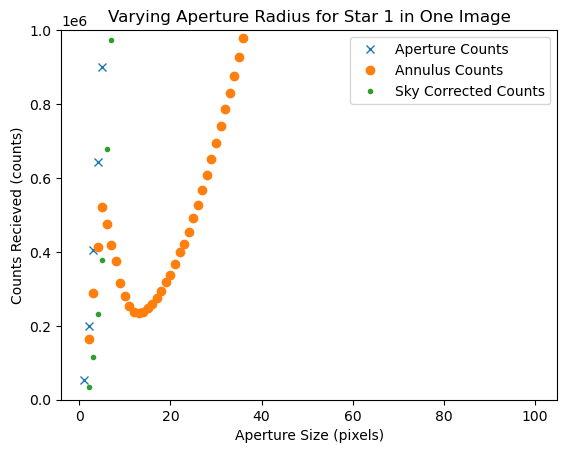

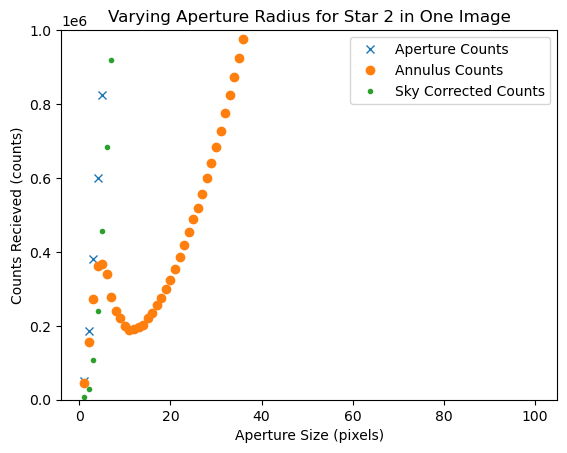

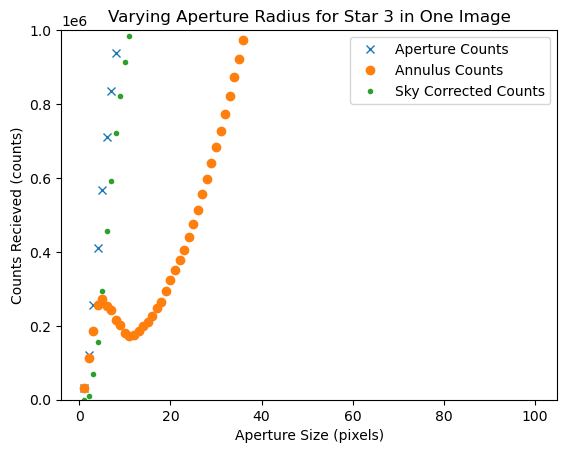

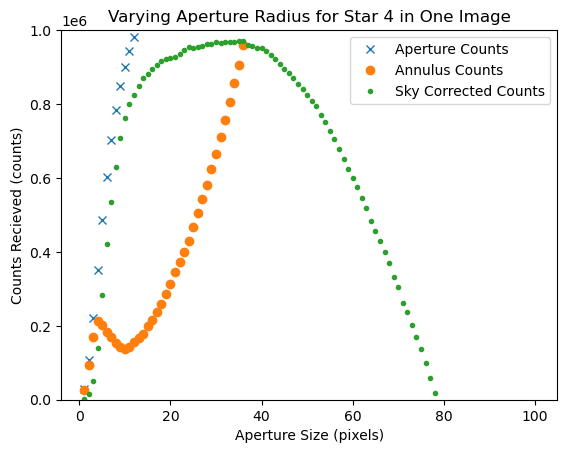

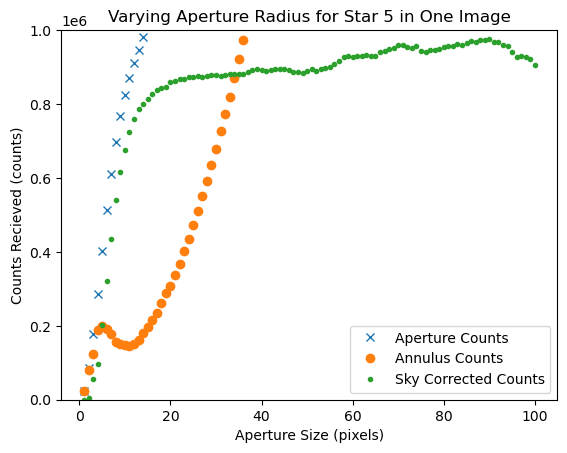

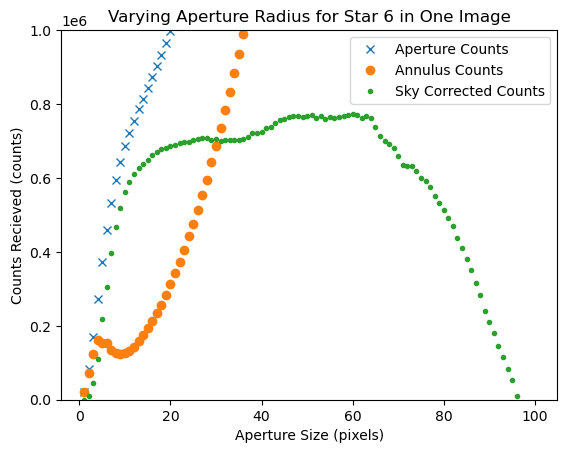

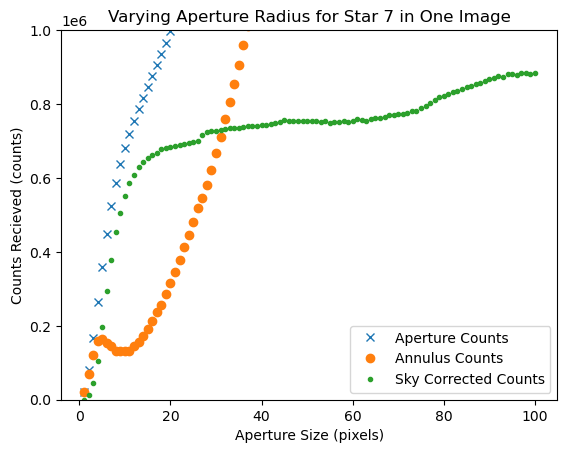

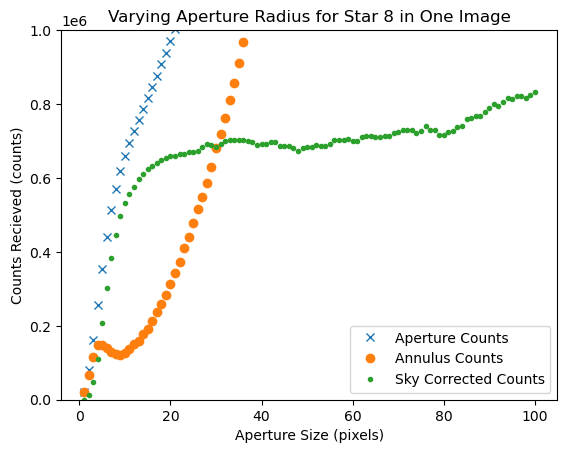

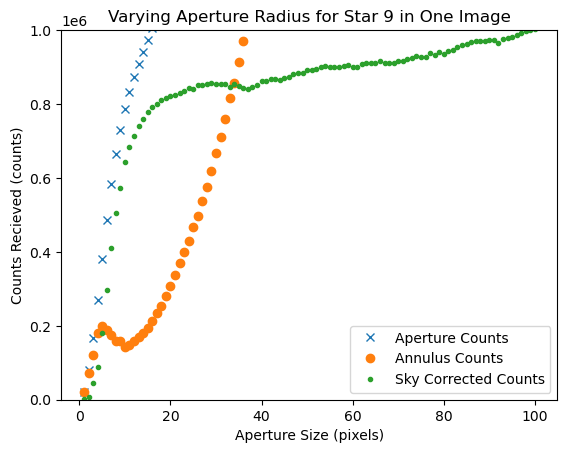

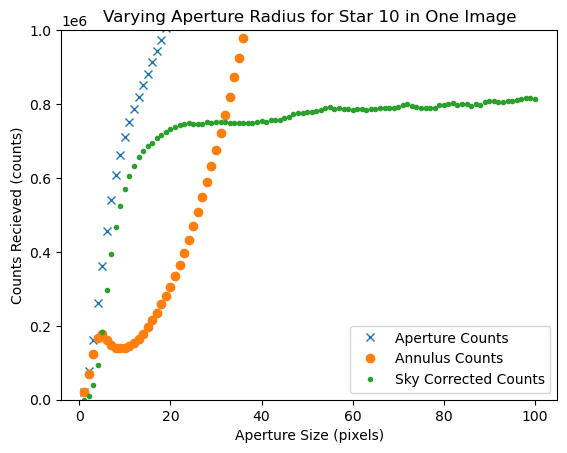

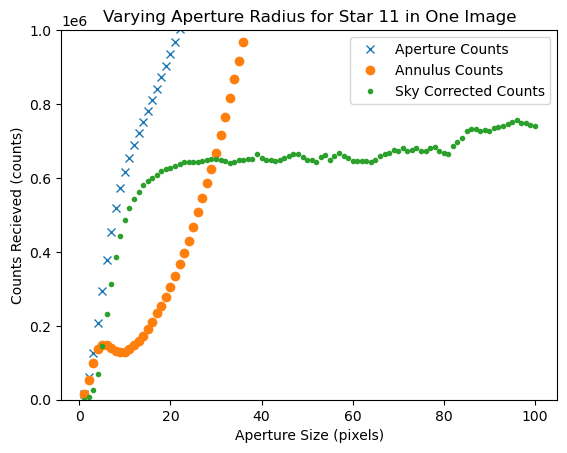

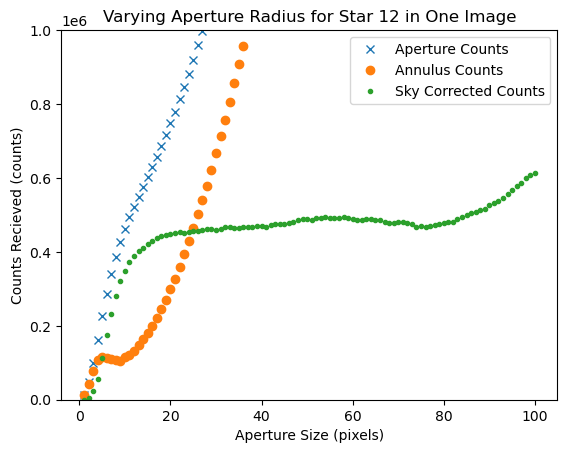

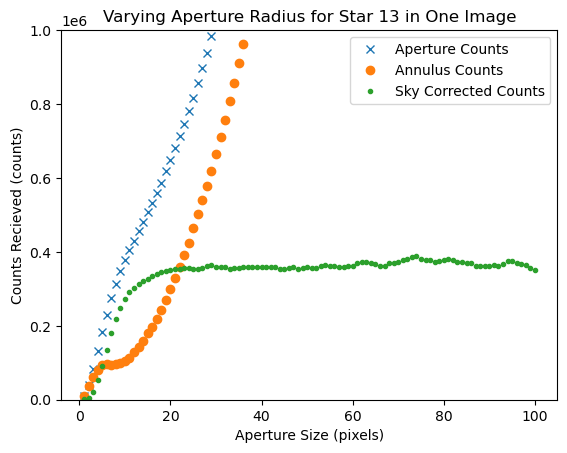

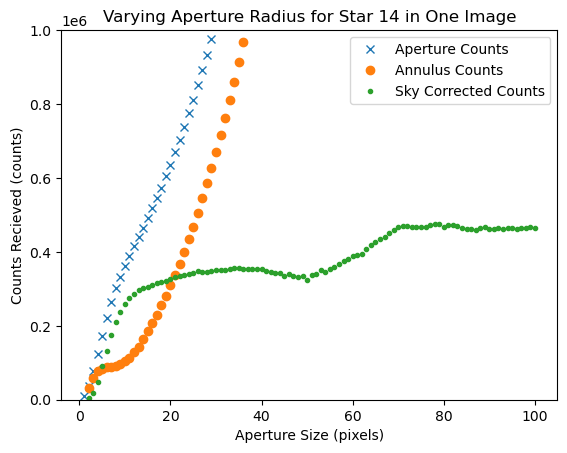

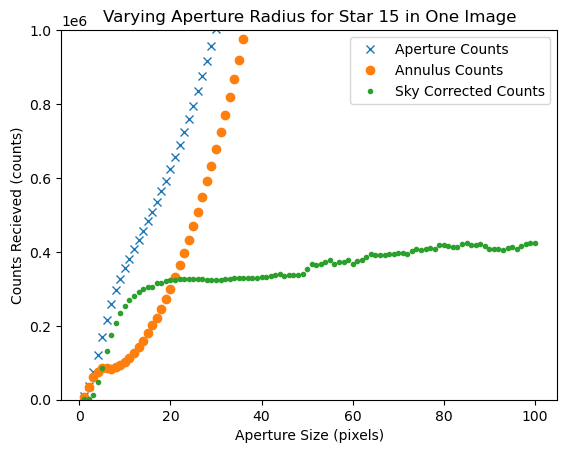

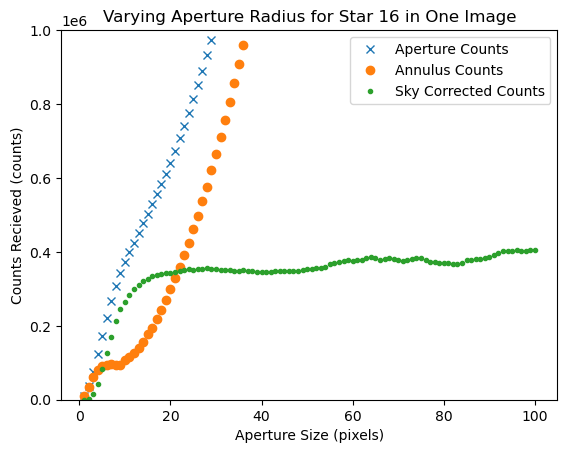

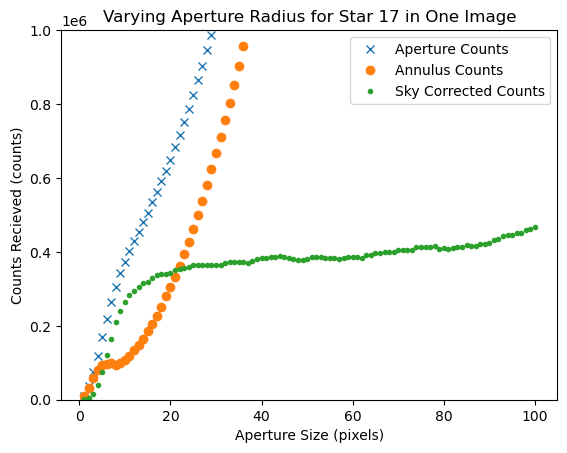

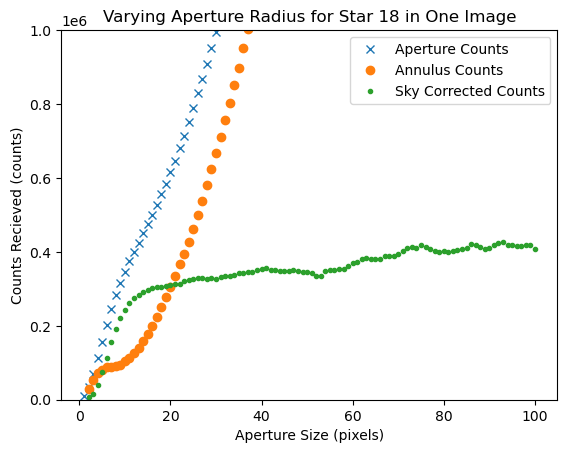

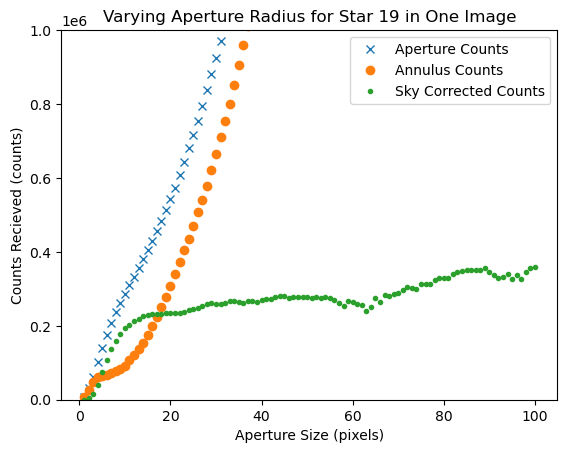

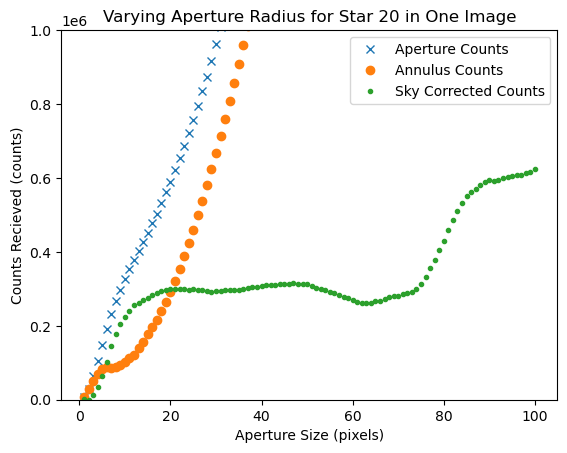

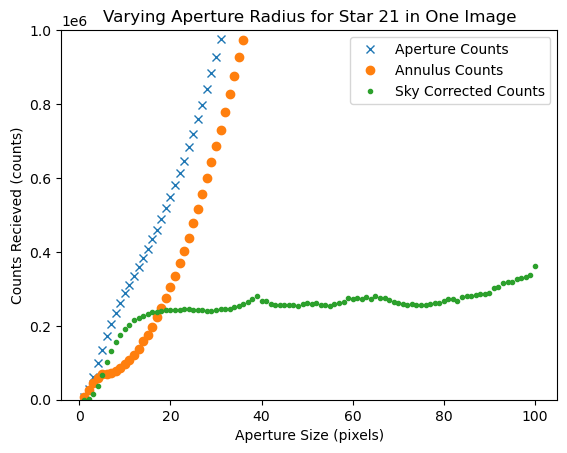

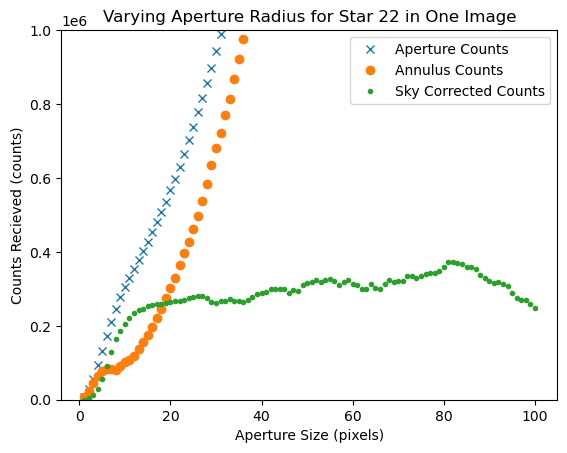

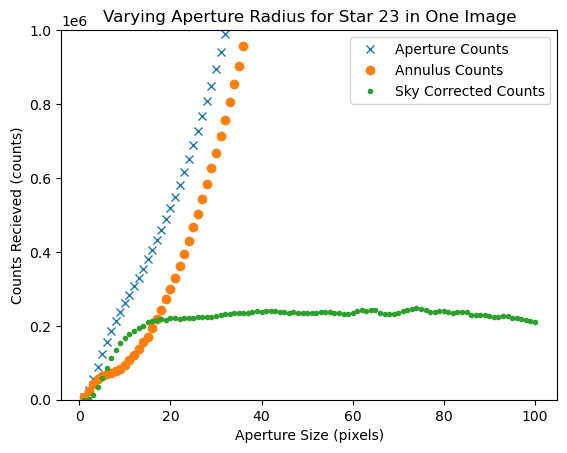

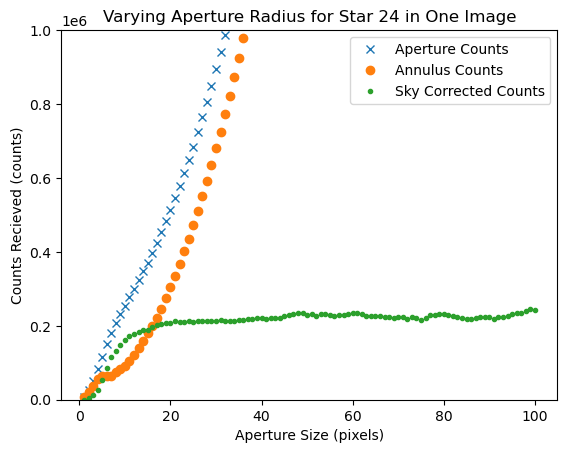

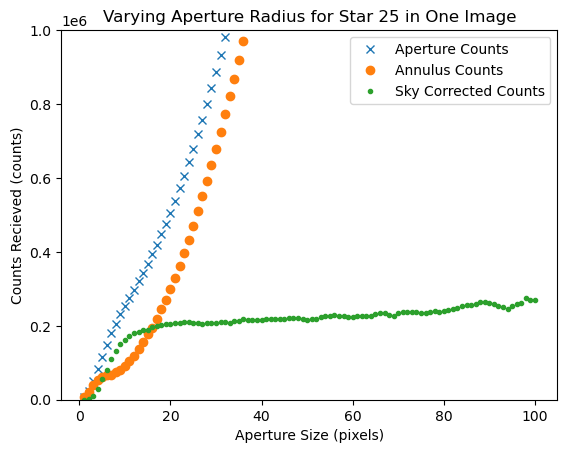

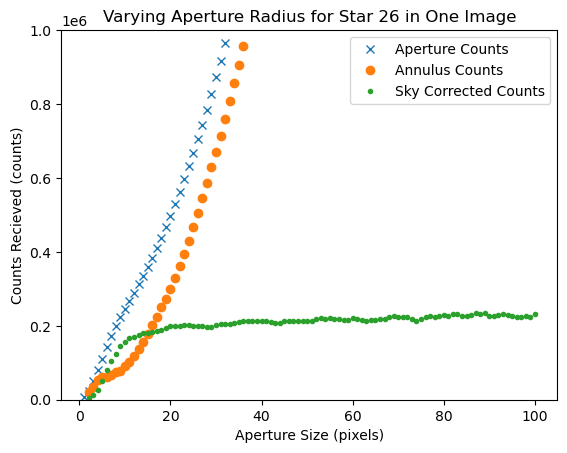

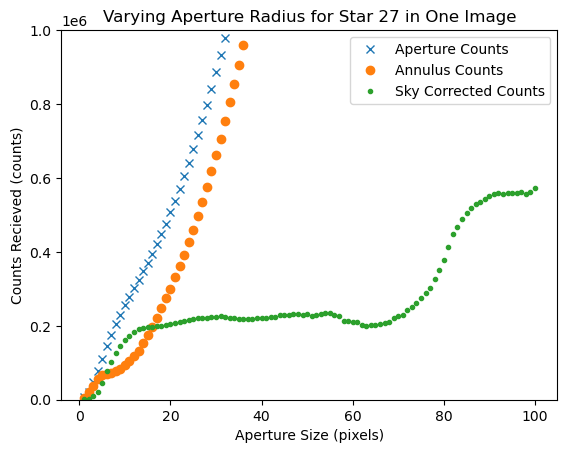

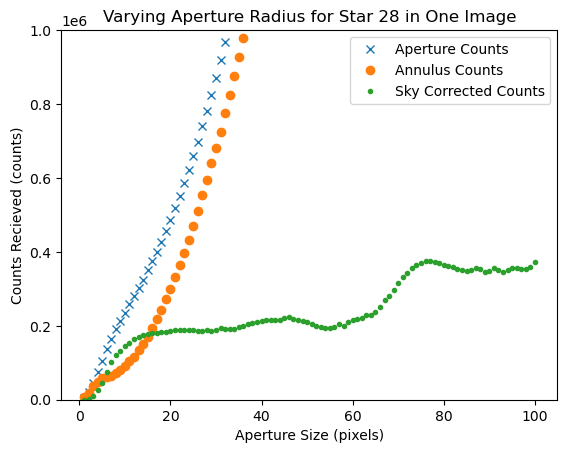

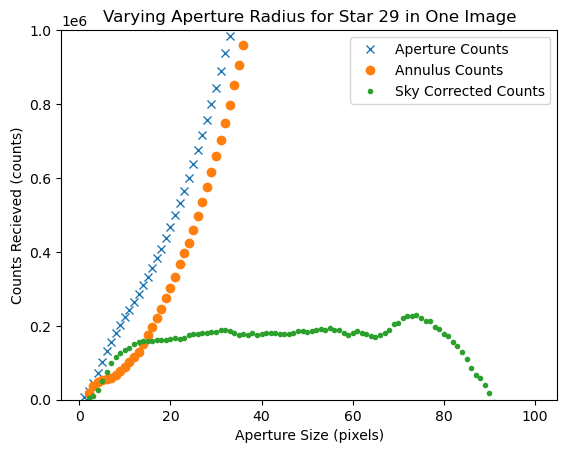

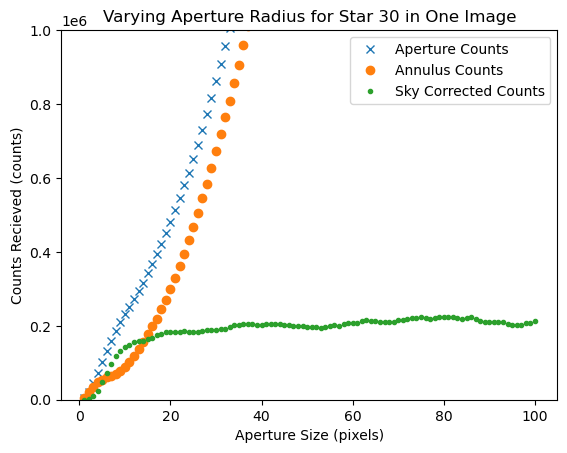

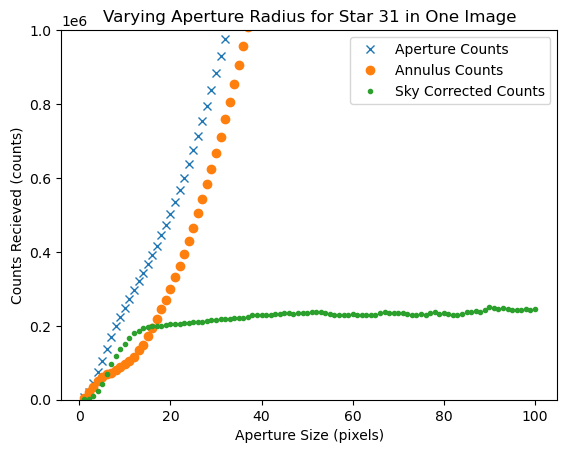

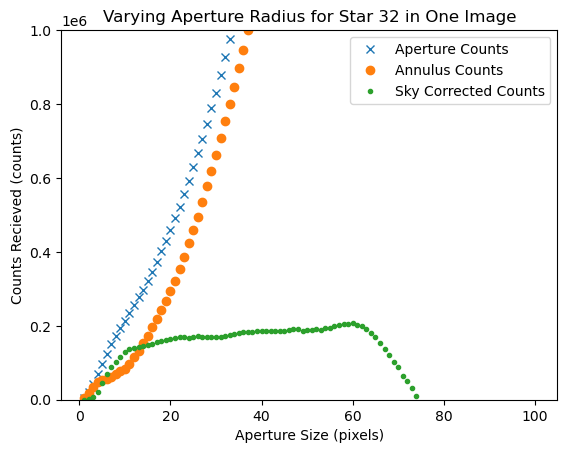

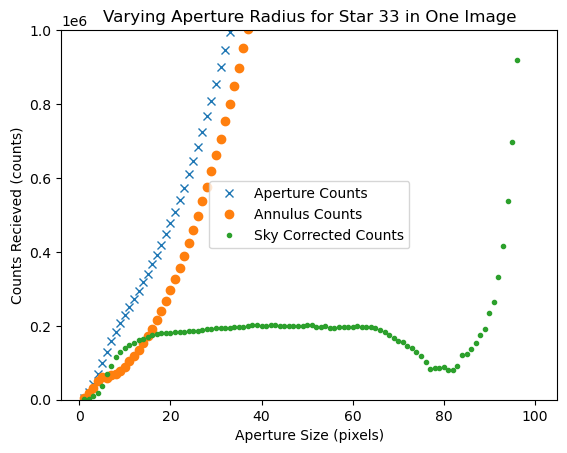

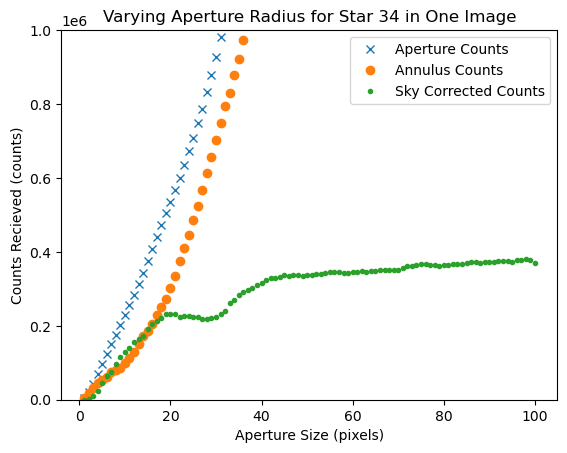

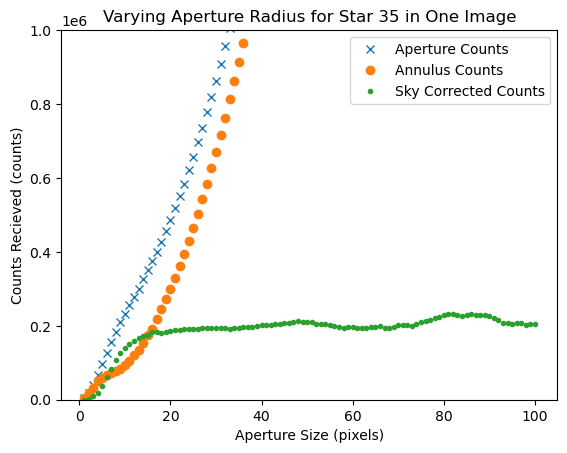

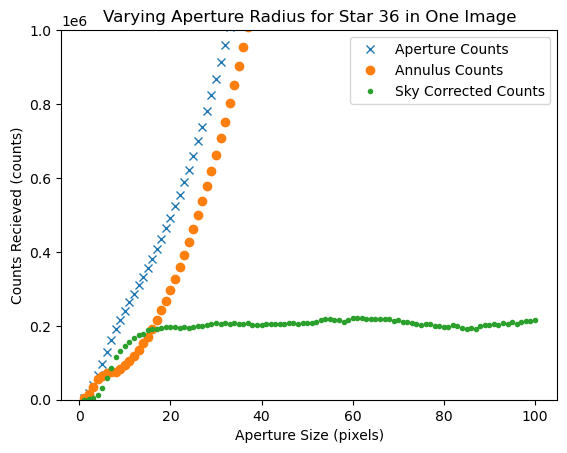

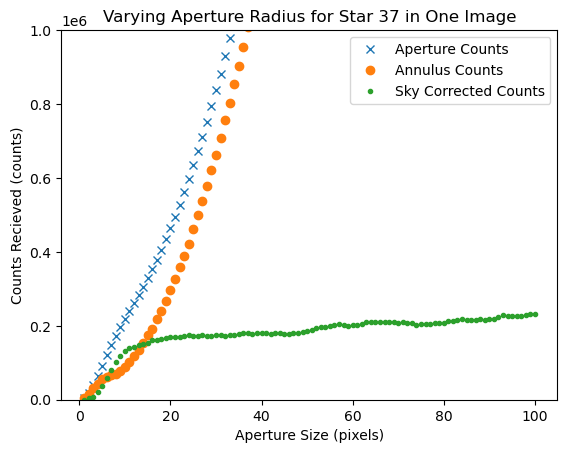

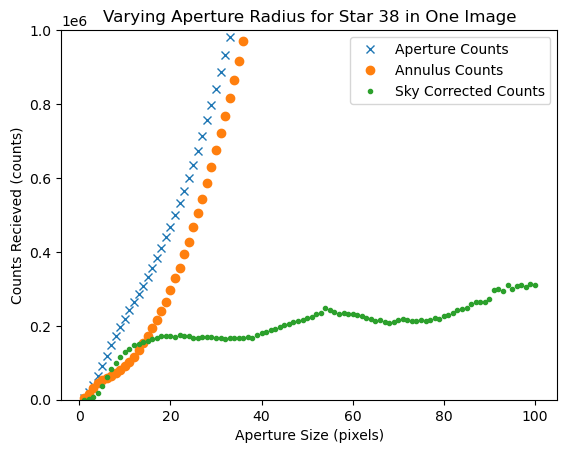

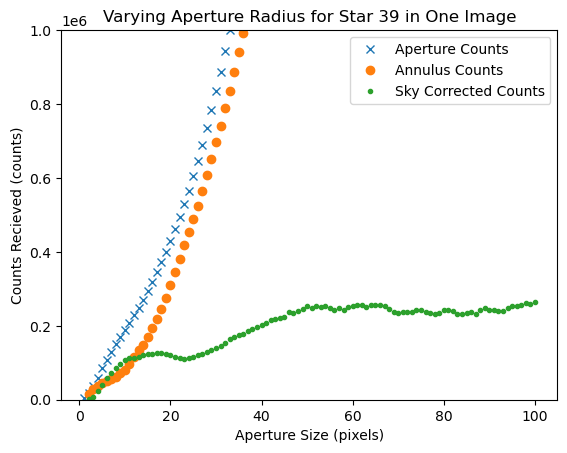

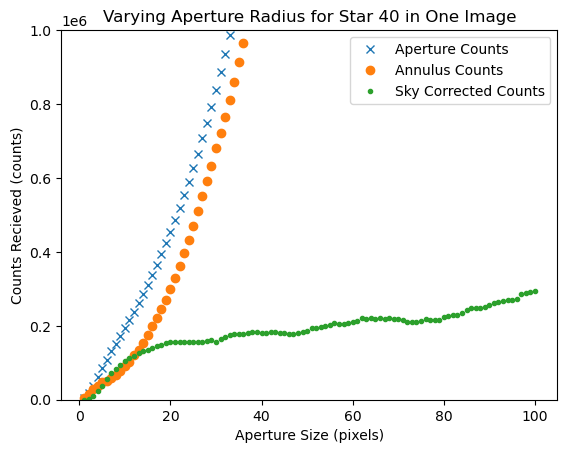

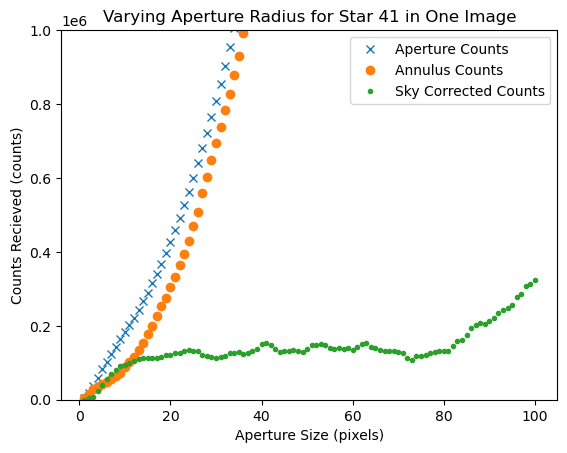

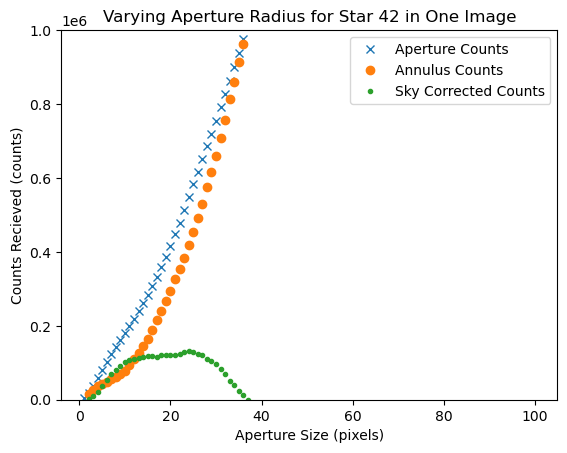

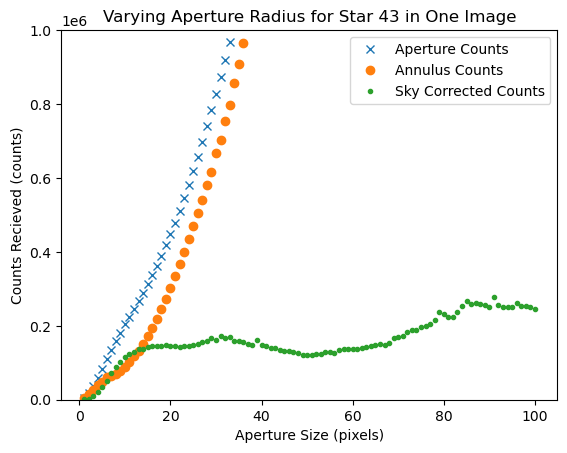

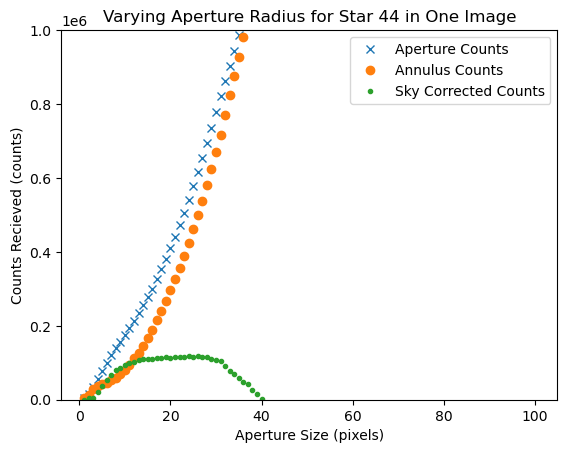

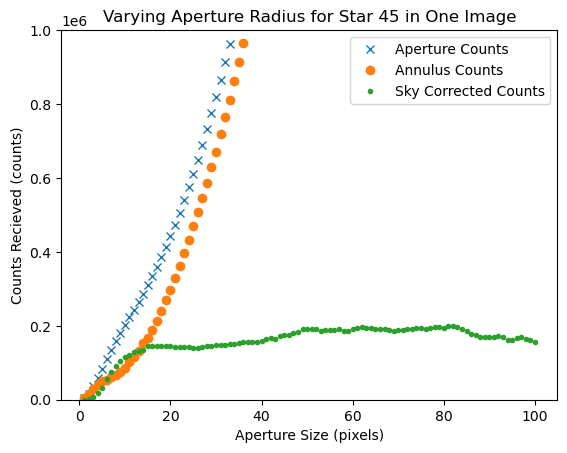

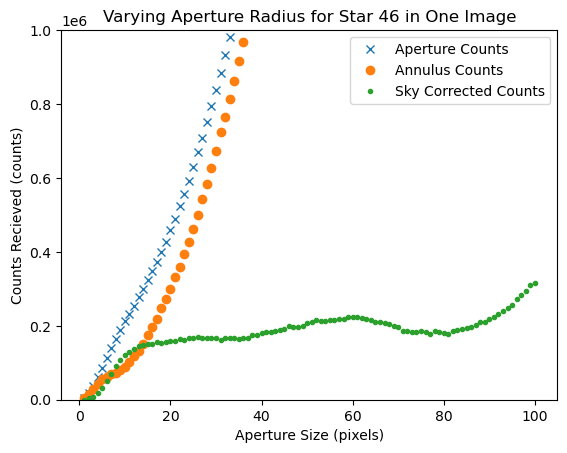

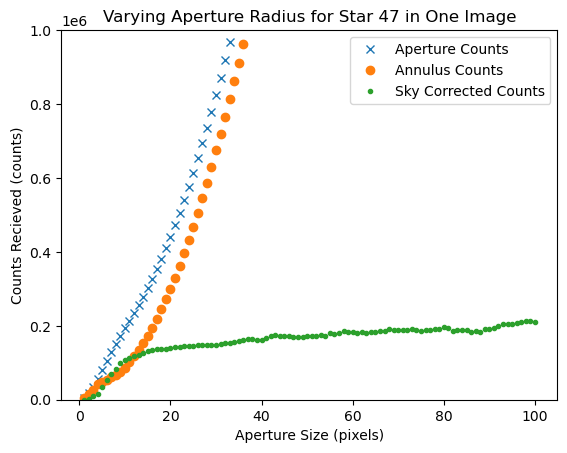

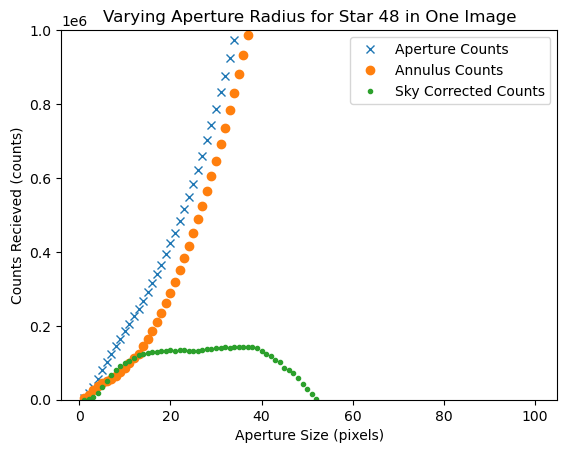

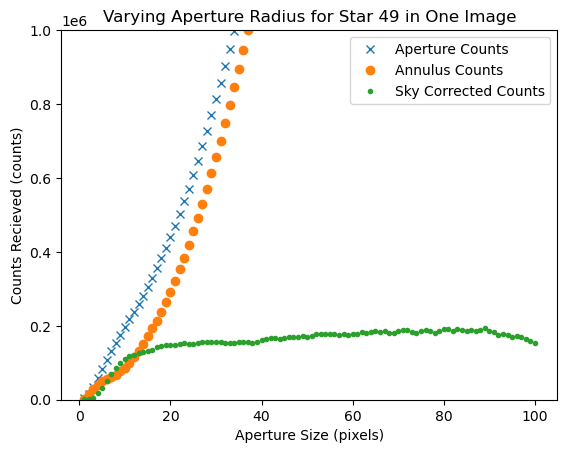

In [17]:
path_x = Path('./RZ Cep/All_RZ_Cep/Photometry Test')
file_list_x = file_list = [f for f in os.listdir(path_x) if f.endswith('.csv')]

ap_flux = []
an_flux = []
sky_corr = []
rad_ap = []
rad_an = []
for j in range(50):
    ap_flux = []
    an_flux = []
    sky_corr = []
    rad_ap = []
    rad_an = []
    for i in range(len(file_list_x)):
        csv = pd.read_csv(path_x / file_list_x[i])
        ap_flux.append(float(csv['counts'][j]))
        an_flux.append(float(csv['annulus_bkg'][j]))
        sky_corr.append(float(csv['sky_corrected_counts'][j]))
        rad_ap.append(float(csv['aperture_radius'][j]))
        rad_an.append(float(csv['annulus_radius'][j]))

    plt.plot(rad_ap, ap_flux, marker='x', ls='None', label='Aperture Counts')
    plt.plot(rad_ap, an_flux, marker='o', ls='None', label='Annulus Counts')
    plt.plot(rad_ap, sky_corr, marker='.', ls='None', label='Sky Corrected Counts')
    plt.legend()
    plt.ylim(0, 1e6)
    plt.title(f'Varying Aperture Radius for Star {j} in One Image')
    plt.xlabel('Aperture Size (pixels)')
    plt.ylabel('Counts Recieved (counts)')
    plt.show()


# Assigning Star IDs to First Image (REF IM) #

In [6]:
#read in the original image and the csv associated with it
raw_im = CCDData.read(raw_path / ref_image_name)
df_ref = pd.read_csv(csv_path / ref_csv_name, delimiter=',')

#get all info Simbad has on our main star
#set up Simbad search
customSimbad = Simbad()
#add fields to output
customSimbad.add_votable_fields('otype','flux(U)','flux(B)','flux(V)','flux(R)','flux(I)','flux(G)','flux(J)','flux(H)',
                                'flux(K)','flux(u)','flux(g)','flux(r)','flux(i)','flux(z)','ra(deg)','dec(deg)','ids')

#search for object and its properties, saving to a dataframe
RZ_Cep = customSimbad.query_object('RZ Cep')
df_RZ_Cep = RZ_Cep.to_pandas()

#find star position in degrees
RZ_Cep_ra = df_RZ_Cep['RA_deg'][0]
RZ_Cep_dec = df_RZ_Cep['DEC_deg'][0]
print(RZ_Cep_ra, RZ_Cep_dec)

#set up Astrometry.net solver, which compares image to the sky to find exact sky position
ast = AstrometryNet()
ast.api_key = 'uktlwsvagbqfbbwl'

#define image size
image_width = raw_im.header['NAXIS1']
image_height = raw_im.header['NAXIS2']
print(image_width, image_height)

#use astrometry.net to match the image data to the sky and find correct coordinates 
wcs_header = ast.solve_from_source_list(df_ref['x_center'], df_ref['y_center'], #input star positions to be compared
                                        image_width, image_height, #image size for matching to the sky
                                        solve_timeout=180, #max time for the solving to be done in
                                        #scale_type='ul',
                                        scale_est = raw_im.header['SCALE'], #check header to see if scaling is required
                                        scale_err = 5, #estimate scale error
                                        #scale_lower = raw_im.header['SCALE'] * 0.9,
                                        #scale_upper = raw_im.header['SCALE'] * 1.1,
                                        scale_units = 'arcsecperpix', #units of scaling
                                        crpix_center=True, #force reference point to be centre of image
                                        center_ra = RZ_Cep_ra, #set image centre as star centre
                                        center_dec = RZ_Cep_dec, 
                                        radius = (raw_im.header['SCALE'] * image_width)/3600 #scale to arcseconds
                                       )

#convert extracted information into a world coordinate system for the image, which is added to the image header
w = WCS(wcs_header)
print(w)
raw_im.header.update(w.to_header(), 'relax')

#change reference point in header to sentre of star rather then image center
raw_im.header['CRPIX1'] = df_ref['x_center'][0]
raw_im.header['CRPIX2'] = df_ref['y_center'][0]

#convert pixel values to ra and dec
sky_all = w.pixel_to_world(df_ref['x_center'], df_ref['y_center'])
#append to original dataframe containing pixel position values, to be saved in csv file
df_ref['ra_from_astrometry_deg'] = sky_all.ra.degree
df_ref['dec_from_astrometry_deg'] = sky_all.dec.degree

#save all stars, their names, ra and dec, Simbad properties within a certain radius of the centre to a dataframe
#set up coordinates associated with 
c = coordinates.SkyCoord(sky_all)
#ensures all stars recieve their id, as a smaller radius means stars close to the edge of the image will not get a proper id
r = 5 * u.arcminute
result_table = customSimbad.query_region(c, radius=r)
df_results = result_table.to_pandas()

#add id to csv file and overwrite it
df_ref['star_id'] = df_results['MAIN_ID']
df_ref = df_ref.drop('Unnamed: 0', axis=1)
df_ref.to_csv(csv_path / ref_csv_name)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


339.80490354369 64.85850316231
4656 3520
Solving.........

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 339.798299884  64.865435723  
CRPIX : 2328.5  1760.5  
CD1_1 CD1_2  : -2.61826663075e-05  0.000132295962147  
CD2_1 CD2_2  : -0.000132255975061  -2.62225510552e-05  
NAXIS : 0  0


In [7]:
#print reference image dataframe to check it
df_ref

,x_center,y_center,annulus_bkg,counts,sky_corrected_counts,counts_error,flux,flux_error,instrumental_mag,mag_error,...,FWHM,date_time,exp_time,sharpness,roundness_sym,roundness_gauss,ellipticity,ra_from_astrometry_deg,dec_from_astrometry_deg,star_id
0,2365.705762,1793.419549,1.430162e+06,3.218034e+06,1.787873e+06,1337.113580,1.787873e+06,1337.113580,-15.630841,0.000812,...,12.224244,2022-12-07T20:08:35.241,5.0,0.441705,0.047472,0.107845,0.008796,339.806508,64.859493,V* RZ Cep
1,3205.681517,1082.780637,1.440411e+06,2.561160e+06,1.120750e+06,1058.654712,1.120750e+06,1058.654712,-15.123772,0.001026,...,12.224244,2022-12-07T20:08:35.241,5.0,0.369768,0.114772,0.002788,0.000502,339.534392,64.766823,TYC 4273-435-1
2,269.975684,3162.320545,1.448484e+06,2.936657e+06,1.488174e+06,1219.907183,1.488174e+06,1219.907183,-15.431634,0.000890,...,12.224244,2022-12-07T20:08:35.241,5.0,0.446571,-0.036590,0.190564,0.020366,340.367187,65.099791,TYC 4273-1351-1
3,2152.512527,68.060537,1.426867e+06,2.083402e+06,6.565354e+05,810.268745,6.565354e+05,810.268745,-14.543145,0.001340,...,12.224244,2022-12-07T20:08:35.241,5.0,0.566439,-0.080746,0.009398,0.007970,339.281247,64.932074,TYC 4273-884-1
4,588.622669,147.266145,1.434745e+06,1.904260e+06,4.695149e+05,685.211603,4.695149e+05,685.211603,-14.179124,0.001584,...,12.224244,2022-12-07T20:08:35.241,5.0,0.584199,-0.139237,0.098695,0.004105,339.399586,65.137152,IRAS 22364+6432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1304.527970,1933.550919,1.444907e+06,1.462441e+06,1.753433e+04,132.417261,1.753433e+04,132.417261,-10.609723,0.008199,...,12.224244,2022-12-07T20:08:35.241,5.0,0.576712,-0.216872,0.228285,0.004328,339.916145,64.996127,UCAC4 776-050768
146,522.077826,1687.660277,1.438928e+06,1.476041e+06,3.711237e+04,192.645706,3.711237e+04,192.645706,-11.423797,0.005636,...,12.224244,2022-12-07T20:08:35.241,5.0,0.647721,0.271351,0.208239,0.003672,339.888024,65.106078,TYC 4273-1186-1
147,550.346508,1417.108832,1.452729e+06,1.475291e+06,2.256148e+04,150.204796,2.256148e+04,150.204796,-10.883419,0.007228,...,12.224244,2022-12-07T20:08:35.241,5.0,0.510255,0.125774,0.610009,0.005855,339.801253,65.109452,NVSS J224004+645852
148,1649.555617,2972.908809,1.437406e+06,1.469049e+06,3.164305e+04,177.884925,3.164305e+04,177.884925,-11.250696,0.006103,...,12.224244,2022-12-07T20:08:35.241,5.0,0.716803,-0.053222,0.287014,0.006920,340.219061,64.922726,TYC 4273-659-1


# Histograms #

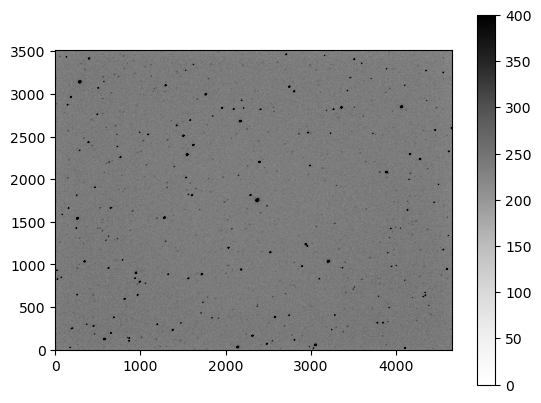

In [16]:
#read in raw image
raw_im = CCDData.read('./RZ Cep/2023_1_23/Photometry Practise/star_Light_Luminance_10_secs_001_reduced.fits')


'''important: images beyond the first few have much less noise, possibly due to absent cloud cover. A lower threshold is needed to detect 200 stars'''
#plot the image, scaling it to see more of the stars
plt.imshow(raw_im.data, cmap='Greys', vmin=0, vmax=400)
#apertures2.plot(color='blue', lw=1.5, alpha=0.5)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [4]:
df = pd.read_csv(file_path / 'star_Light_Luminance_10_secs_078_reduced_stars.csv')
df

,Unnamed: 0,x_center,y_center,annulus_bkg,counts,sky_corrected_counts,flux,instrumental_mag,saturated?,FWHM,date_time,exp_time,sharpness,roundness_sym,roundness_gauss,ellipticity
0,0,2309.535543,1704.991636,647887.665814,3.232790e+06,2.584902e+06,2.584902e+06,-16.031110,False,12.110281,2023-01-24T00:03:48.297,10.0,0.517936,0.619844,-0.117763,0.058455
1,1,3136.553381,980.926520,621284.500832,2.149854e+06,1.528569e+06,1.528569e+06,-15.460713,False,12.110281,2023-01-24T00:03:48.297,10.0,0.531262,0.501945,-0.120968,0.041958
2,2,239.715322,3108.732048,624643.350874,2.579487e+06,1.954844e+06,1.954844e+06,-15.727780,False,12.110281,2023-01-24T00:03:48.297,10.0,0.452084,0.555872,-0.213747,0.046090
3,3,4009.701420,2787.602685,622707.014263,1.729840e+06,1.107133e+06,1.107133e+06,-15.110499,False,12.110281,2023-01-24T00:03:48.297,10.0,0.476532,0.578983,-0.321578,0.047852
4,4,2976.724274,2.881491,621388.244406,7.851970e+05,1.638088e+05,1.638088e+05,-13.035843,False,12.110281,2023-01-24T00:03:48.297,10.0,0.480175,0.071531,-0.432656,0.243338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,3736.711535,714.815466,631864.837546,6.441129e+05,1.224801e+04,1.224801e+04,-10.220164,False,12.110281,2023-01-24T00:03:48.297,10.0,0.570352,0.265401,-0.326735,0.009561
196,196,459.733969,1390.180651,645711.732847,6.685942e+05,2.288245e+04,2.288245e+04,-10.898756,False,12.110281,2023-01-24T00:03:48.297,10.0,0.356612,0.650537,0.241224,0.022457
197,197,1595.959988,94.476676,617182.795302,6.419797e+05,2.479693e+04,2.479693e+04,-10.985995,False,12.110281,2023-01-24T00:03:48.297,10.0,0.931370,0.704115,0.088685,0.005261
198,198,3558.936127,2682.291828,606804.855180,6.410578e+05,3.425291e+04,3.425291e+04,-11.336744,False,12.110281,2023-01-24T00:03:48.297,10.0,0.425566,0.644790,-0.185644,0.006092


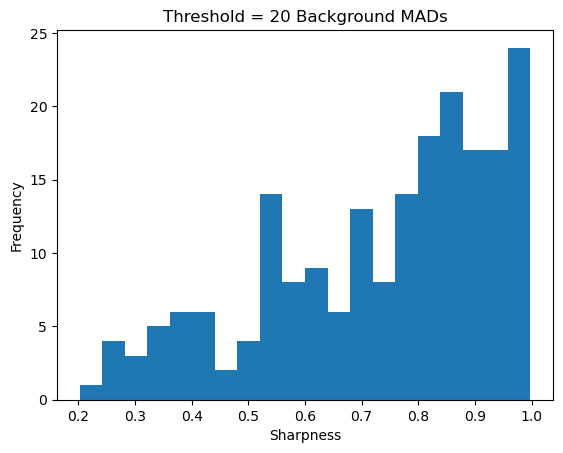

In [5]:
n_bins = 20
plt.hist(df['sharpness'], bins=n_bins)
plt.xlabel('Sharpness')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()
#ratio of difference between highest pixel value and mean of surrounding pixels

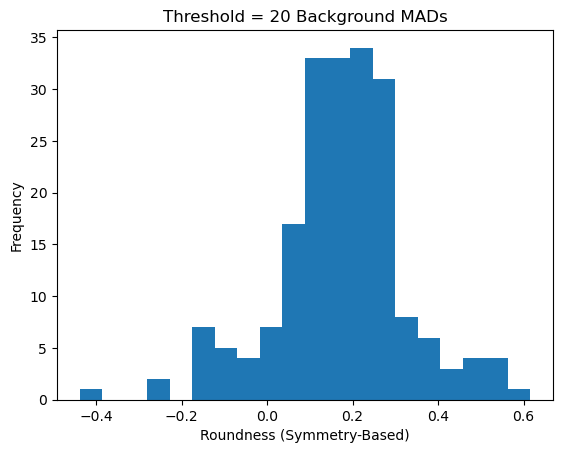

In [6]:
n_bins = 20
plt.hist(df['roundness_sym'], bins=n_bins)
plt.xlabel('Roundness (Symmetry-Based)')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()
#circular has 0 roundness, negative roundness is extended in x, positive extended in y

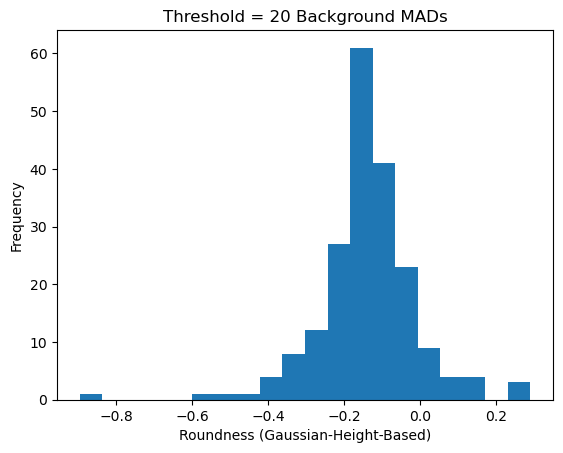

In [7]:
n_bins = 20
plt.hist(df['roundness_gauss'], bins=n_bins)
plt.xlabel('Roundness (Gaussian-Height-Based)')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()
#calculated using height difference of Gaussians in x and y direction

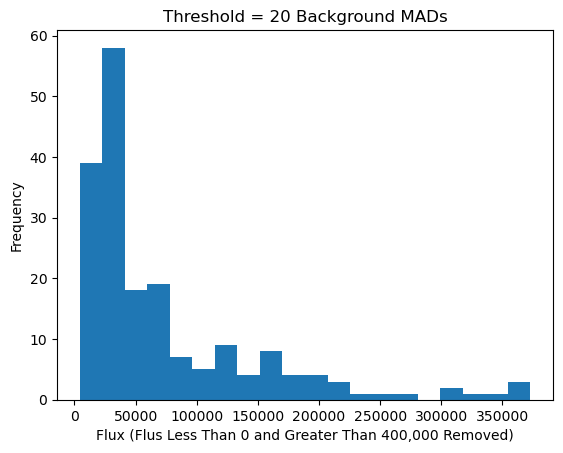

In [8]:
n_bins = 20
#remove outliers
i = 0
flux_plot = []
while i < 200:
    if df['flux'][i] < 0:
        i += 1
    elif df['flux'][i] > 4e5:
        i += 1
    else:
        flux_plot.append(df['flux'][i])
        i += 1

plt.hist(flux_plot, bins=n_bins)
plt.xlabel('Flux (Flus Less Than 0 and Greater Than 400,000 Removed)')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()
#calculated from aperture photometry

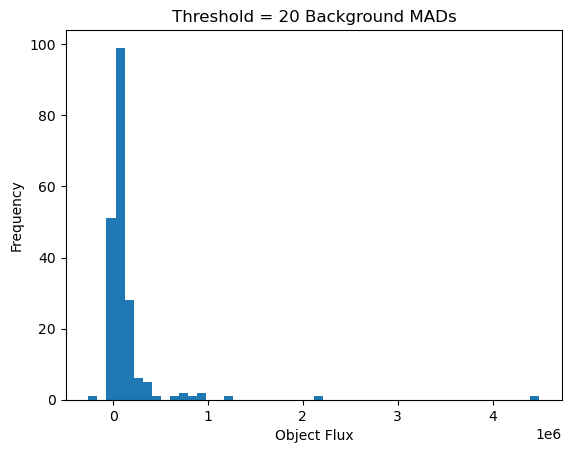

In [9]:
n_bins = 50
plt.hist(df['flux'], bins=n_bins)
plt.xlabel('Object Flux')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()

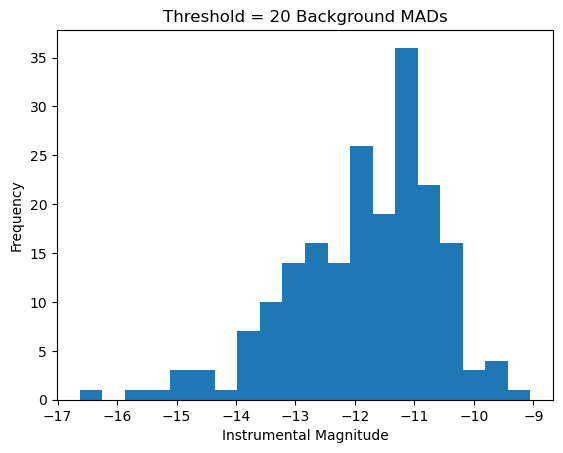

In [10]:
n_bins = 20
plt.hist(df['instrumental_mag'], bins=n_bins)
plt.xlabel('Instrumental Magnitude')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()